In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

# Игнорирование сообщений с предупреждениями
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Мониторинг состояния воздуха
# Загрузка датасета
data = pd.read_csv('/content/AirQualityData.csv')
data.head()

,Date,Time,CO(GT),NOx(GT),NO2(GT),O3(GT),SO2(GT),PM2.5,PM10,Temperature,...,WindDirection,CO_NOx_Ratio,NOx_NO2_Ratio,Temp_Humidity_Index,AirQualityIndex,CO_MA3,NO2_MA3,O3_MA3,DayOfWeek,Hour
0,2024-01-01,00:00,3.807947,172.026768,144.333317,118.120832,1.215679,147.349671,208.803124,28.564580,...,209.984267,0.022008,1.183671,3.541778,343.353046,3.807947,144.333317,118.120832,0,0
1,2024-01-01,01:00,9.512072,241.824266,137.769318,15.325830,1.016178,40.979839,145.595579,6.793192,...,319.534890,0.039173,1.742635,0.727989,206.282028,6.660009,141.051317,66.723331,0,1
2,2024-01-01,02:00,7.346740,228.288118,20.055086,44.377036,24.140910,72.594740,26.155000,24.436552,...,274.644300,0.032042,10.842422,7.378322,140.170920,6.888920,100.719240,59.274566,0,2
3,2024-01-01,03:00,6.026719,47.016072,184.591909,139.488603,2.435392,134.339724,276.367944,26.463951,...,312.266023,0.125515,0.253330,21.684266,307.928588,7.628510,114.138771,66.397156,0,3
4,2024-01-01,04:00,1.644585,45.625591,114.125968,95.634768,48.752095,99.007422,294.295449,10.530331,...,21.392120,0.035272,0.396310,9.627596,370.134556,5.006015,106.257654,93.166802,0,4


In [3]:
# Общая информация
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 4000 non-null   object 
 1   Time                 4000 non-null   object 
 2   CO(GT)               4000 non-null   float64
 3   NOx(GT)              4000 non-null   float64
 4   NO2(GT)              4000 non-null   float64
 5   O3(GT)               4000 non-null   float64
 6   SO2(GT)              4000 non-null   float64
 7   PM2.5                4000 non-null   float64
 8   PM10                 4000 non-null   float64
 9   Temperature          4000 non-null   float64
 10  Humidity             4000 non-null   float64
 11  Pressure             4000 non-null   float64
 12  WindSpeed            4000 non-null   float64
 13  WindDirection        4000 non-null   float64
 14  CO_NOx_Ratio         4000 non-null   float64
 15  NOx_NO2_Ratio        4000 non-null   f

 Датасет содержит 23 поля предоставляющих следующую информацию:

Date (object) - дата наблюдения в формате YYYY-MM-DD. Для каждой даты имеется до 24 записей о наблюдениях с уникальным временем наблюдения. Наблюдения охватывают период в 167 дней с 01.01.2024 по 15.06.2024

Time (object) - время наблюдения в формате HH:MM. Для каждой даты за исключением 15.06.2024 проведено 24 наблюдения с интервалом в 1 час. Поле содержит 24 уникальных значения от 00:00 до 23:00

Поскольку при анализе и для построения временного ряда будут использоваться все записи, поля Date и Time целесообразно объединить в одно поле типа (DateTime), содержащее полную временную метку формата YYYY-MM-DD HH:MM, или заменить полем типа (int64), содержащим порядковый номер наблюдения от 1 до 4000.

-----------------------------

CO(GT) (float64) - концентрация угарного газа (CO) в мг/м3

NOx(GT) (float64) - концентрация различных оксидов азота (NOx) кроме NO2 в миллиардных долях (ppb)

NO2(GT) (float64) - концентрация диоксида азота (NO2) в миллиардных долях (ppb)

O3(GT) (float64) - концентрация озона (O3) в миллиардных долях (ppb)

SO2(GT) (float64) - концентрация диоксида серы (SO2) в миллиардных долях (ppb)

PM2.5 (float64) - концентрация мелких твердых частиц в воздухе в мкг/м3

PM10 (float64) - концентрация крупных твердых частиц в воздухе в мкг/м3

-----------------------------

Temperature (float64) - температура воздуха в °С

Humidity (float64) - влажность воздуха в %

Pressure (float64) - атмосферное давление в мбар

WindSpeed (float64) - скорость ветра в м/с

WindDirection (float64) - направление ветра в °

-----------------------------

CO_NOx_Ratio (float64) - соотношение содержания угарного газа и оксидов азота

NOx_NO2_Ratio (float64) - соотношение содержания прочих оксидов азота и NO2

Temp_Humidity_Index (float64) - индекс температуры и влажности (THI)

AirQualityIndex (float64) - индекс качества воздуха. Количественно оценивается, как правило, от 0 до 500 (чем меньше, тем лучше). Качественная и количественная оценка зависит от государства и специфики расчета. При необходимости будет использоваться американская цветовая система оценки:
0-50    | Good                  | Зеленый
51-100  | Moderate              | Желтый
101-150 | Unhealthy (Sensitive) | Оранжевый
151-200 | Unhealthy             | Красный
201-300 | Very Unhealthy        | Фиолетовый
301-500 | Hazardous             | Бордовый

CO_MA3 (float64) - скользящее среднее значение концентрации угарного газа

NO2_MA3 (float64) - скользящее среднее значение концентрации диоксида азота

O3_MA3 (float64) - скользящее среднее значение концентрации озона

DayOfWeek (int64) - день недели. Дни недели представлены целыми числами [0:6]. 0 - понедельник. Целесообразно дополнительно изучить влияние данного параметра, поскольку производственный календарь влияет на выброс отходов в атмосферу, однако производственный календарь связан не только со структурой недели.

Hour (int64) - часы с начала суток. Представлены целыми числами [0:23]. Дублирование информации с полем Time. Целесообразно исключить как дублирующую информацию.

In [4]:
# Проверка на пустые значения
data.isnull().sum()

,0
Date,0
Time,0
CO(GT),0
NOx(GT),0
NO2(GT),0
O3(GT),0
SO2(GT),0
PM2.5,0
PM10,0
Temperature,0


Датасет не содержит пустых значений

In [7]:
# Проверка на наличие дубликатов
data.duplicated().sum()

np.int64(0)

Датасет не содержит дублирующихся записей

In [8]:
# Общие характеристики
data.describe()

,CO(GT),NOx(GT),NO2(GT),O3(GT),SO2(GT),PM2.5,PM10,Temperature,Humidity,Pressure,...,WindDirection,CO_NOx_Ratio,NOx_NO2_Ratio,Temp_Humidity_Index,AirQualityIndex,CO_MA3,NO2_MA3,O3_MA3,DayOfWeek,Hour
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,...,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,5.025385,148.126633,100.213189,89.914815,26.081045,104.765999,153.591417,17.305228,54.626284,999.862679,...,179.571724,0.082564,3.412176,9.418823,249.602455,5.025846,100.222672,89.901700,2.978000,11.484000
std,2.874632,85.999247,57.074947,52.003484,14.059684,56.344868,83.080911,12.943632,25.844003,28.897118,...,104.738760,0.215593,7.996062,8.982090,143.570929,1.672715,32.884870,30.505331,1.992614,6.919951
min,0.100115,1.009185,1.010513,1.055442,1.012370,5.009384,10.031967,-4.996963,10.000498,950.018004,...,0.033694,0.000389,0.006021,-4.824570,0.052355,0.612983,3.702628,7.453898,0.000000,0.000000
25%,2.514242,73.636615,51.326622,44.179487,14.220565,56.544378,82.200105,6.092531,31.970628,975.018939,...,86.409827,0.017033,0.719052,2.551932,124.521801,3.846779,77.100651,68.321846,1.000000,5.000000
50%,5.054973,146.440690,99.508855,88.956924,26.321359,105.502686,154.714484,17.184773,55.113650,999.857722,...,179.401393,0.034021,1.467460,6.975287,250.552671,5.042259,100.128466,90.452301,3.000000,11.000000
75%,7.524652,221.823697,149.666167,136.333683,37.833728,153.751364,222.969347,28.573093,76.311009,1024.763352,...,272.370032,0.065973,2.789423,14.752847,370.997732,6.206658,123.919621,111.337587,5.000000,17.000000
max,9.997205,299.838744,199.934968,179.986544,49.993700,199.980691,299.911727,39.987944,99.981043,1049.926869,...,359.984504,4.078615,131.169948,39.372679,499.920650,9.471079,190.781333,173.546840,6.000000,23.000000


In [9]:
# Формирование единого поля даты и времени
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
data.set_index('DateTime', inplace=True)
data.drop(['Date', 'Time'], axis=1, inplace=True)

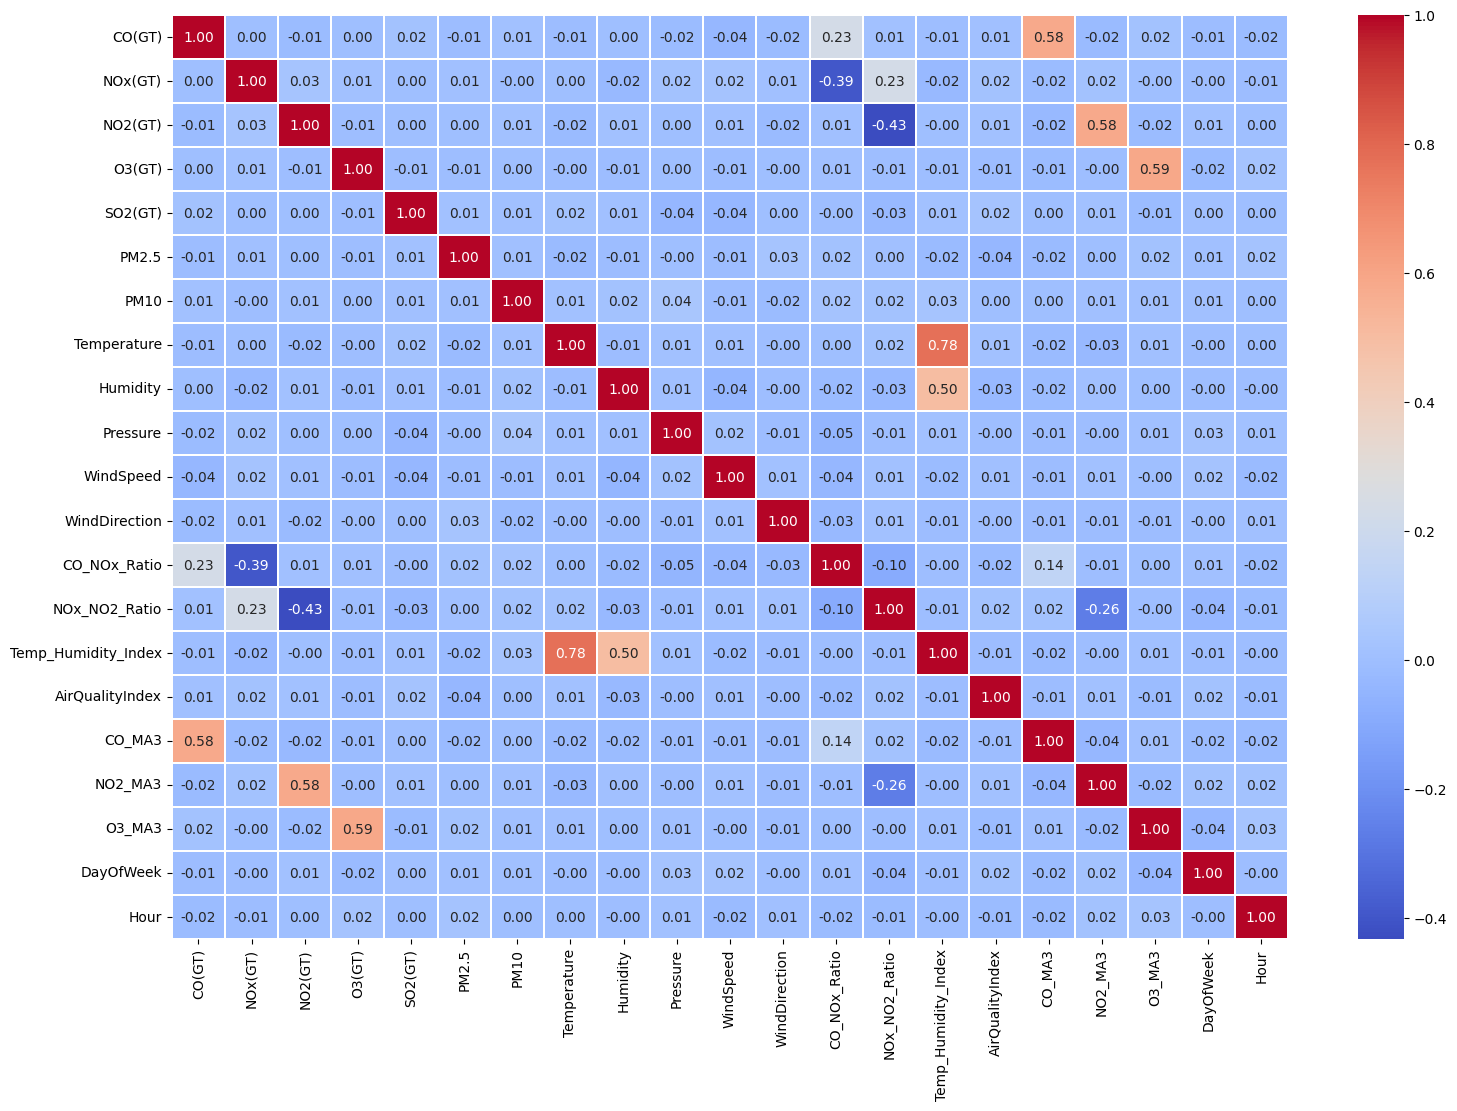

In [10]:
# Корреляция параметров
plt.figure(figsize=(18,12))
sns.heatmap(data.corr(), cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.01)
plt.show()

Высокая корреляция между отдельными параметрами связана с тем, что ряд параметров в датасете является производными от других параметров датасета

Целесообразно рассмотреть варианты, когда учитываются отдельно Temperature и Humidity и когда учитывается производный от них параметр Temp_Humidity_Index

Пары между значениями концентрации отдельных газов и их плавающих средних значений также достаточно сильно коррелируют между собой

Число выбросов в параметре:
 CO(GT)                   0
NOx(GT)                  0
NO2(GT)                  0
O3(GT)                   0
SO2(GT)                  0
PM2.5                    0
PM10                     0
Temperature              0
Humidity                 0
Pressure                 0
WindSpeed                0
WindDirection            0
CO_NOx_Ratio           459
NOx_NO2_Ratio          444
Temp_Humidity_Index     57
AirQualityIndex          0
CO_MA3                   0
NO2_MA3                  2
O3_MA3                   0
DayOfWeek                0
Hour                     0
dtype: int64


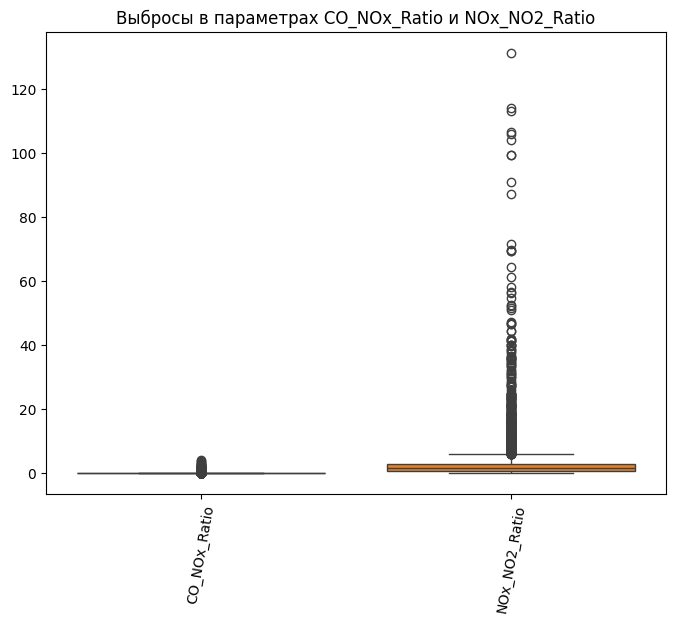

In [19]:
# Поиск выбросов по IQR
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).sum()
print("Число выбросов в параметре:\n", outliers)

plt.figure(figsize=(8,6))
sns.boxplot([data['CO_NOx_Ratio'], data['NOx_NO2_Ratio']])
plt.xticks(rotation = 80)
plt.title('Выбросы в параметрах CO_NOx_Ratio и NOx_NO2_Ratio')
plt.show()

Большое количество выбросов для производных параметров CO_NOx_Ratio и NOx_NO2_Ratio говорит об их потенциальной нестабильности. В случае использования этих параметров в дальнейшем целесообразно дополнительно подготовить их во избежание нестабильности модели.

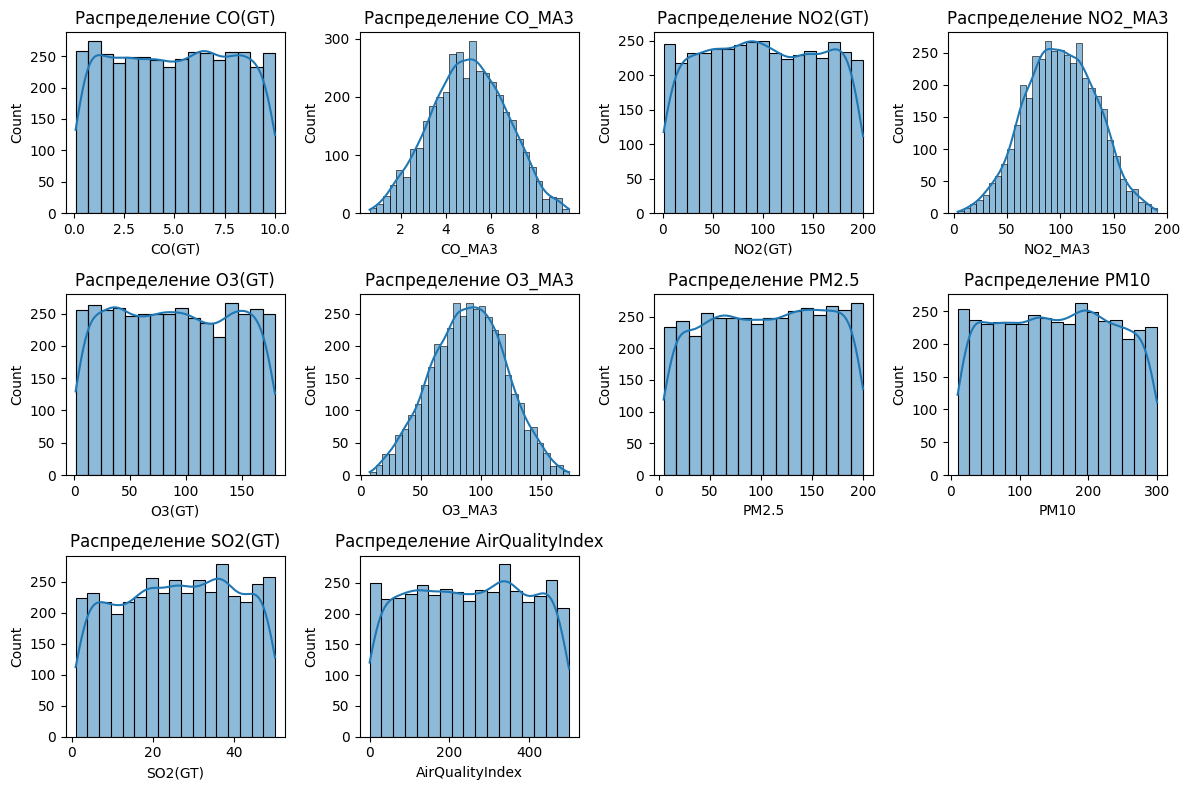

In [28]:
# Визуализация распределения параметров
plt.figure(figsize=(12, 8))
for i, col in enumerate(['CO(GT)', 'CO_MA3','NO2(GT)', 'NO2_MA3',
                         'O3(GT)', 'O3_MA3', 'PM2.5',	'PM10','SO2(GT)',
                         'AirQualityIndex']):
    plt.subplot(3, 4, i+1)
    sns.histplot(data[col], kde=True)
    plt.title(f'Распределение {col}')
plt.tight_layout()
plt.show()

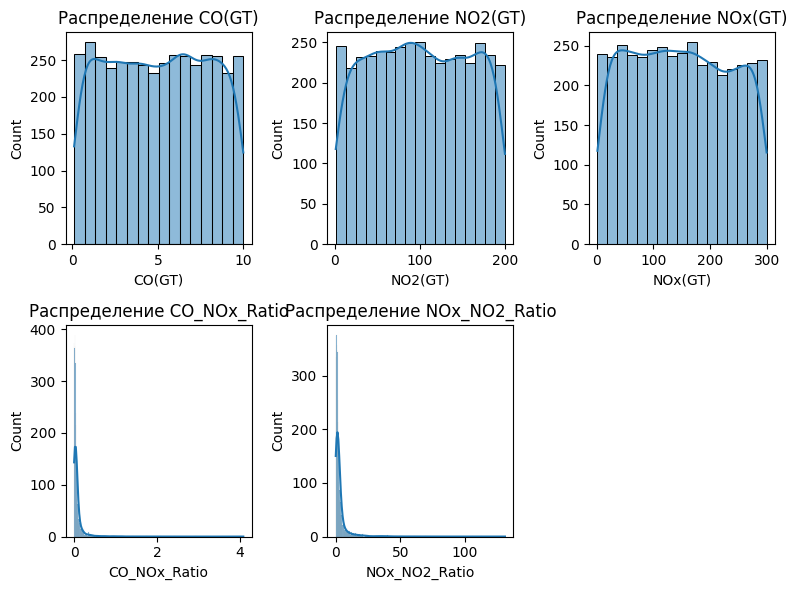

In [30]:
# Визуализация распределения параметров
plt.figure(figsize=(8, 6))
for i, col in enumerate(['CO(GT)', 'NO2(GT)', 'NOx(GT)',
                         'CO_NOx_Ratio',	'NOx_NO2_Ratio']):
    plt.subplot(2, 3, i+1)
    sns.histplot(data[col], kde=True)
    plt.title(f'Распределение {col}')
plt.tight_layout()
plt.show()

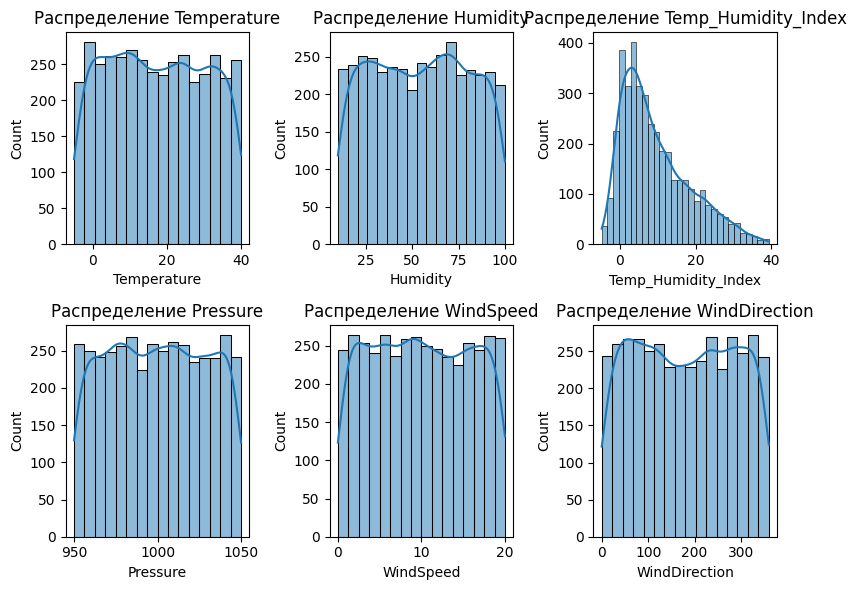

In [31]:
plt.figure(figsize=(8, 6))
for i, col in enumerate(['Temperature',	'Humidity',	'Temp_Humidity_Index',
                         'Pressure', 'WindSpeed', 'WindDirection', ]):
    plt.subplot(2, 3, i+1)
    sns.histplot(data[col], kde=True)
    plt.title(f'Распределение {col}')
plt.tight_layout()
plt.show()

In [33]:
# Определение признаков и целевого параметра

X = data.drop(['AirQualityIndex'], axis=1)
y = data['AirQualityIndex']

Ни один параметр из датасета на этом этапе не исключался с тем, чтобы проверить в будущем, как их наличие/отсутствие влияет на обучение модели

In [34]:
# Подготовка тренировочных и тестовых данных

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Тренировочные данные:", X_train_scaled.shape)
print("Тестовые данные:", X_test_scaled.shape)

Тренировочные данные: (3200, 20)
Тестовые данные: (800, 20)
